# Chapter 2 - End-to-end ML Project

In this chapter, we try to build a first ml project. We use the california census data to predict housing prices.

## Download data

The data we need must be 1. downloaded, 2. extracted 3. read into pandas using csv file. In order to redownload the data we write a small script and function

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()


In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

## Take a look at the data

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`total_bedrooms` has fewer values. Missing data! ocean_proximity is not a float, but a text. Inspect it further

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


For a quick overview, it is good to plot a histogram of all numerical values. Hist can be called on the whole datasset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255B3940FD0>,
      dtype=object)

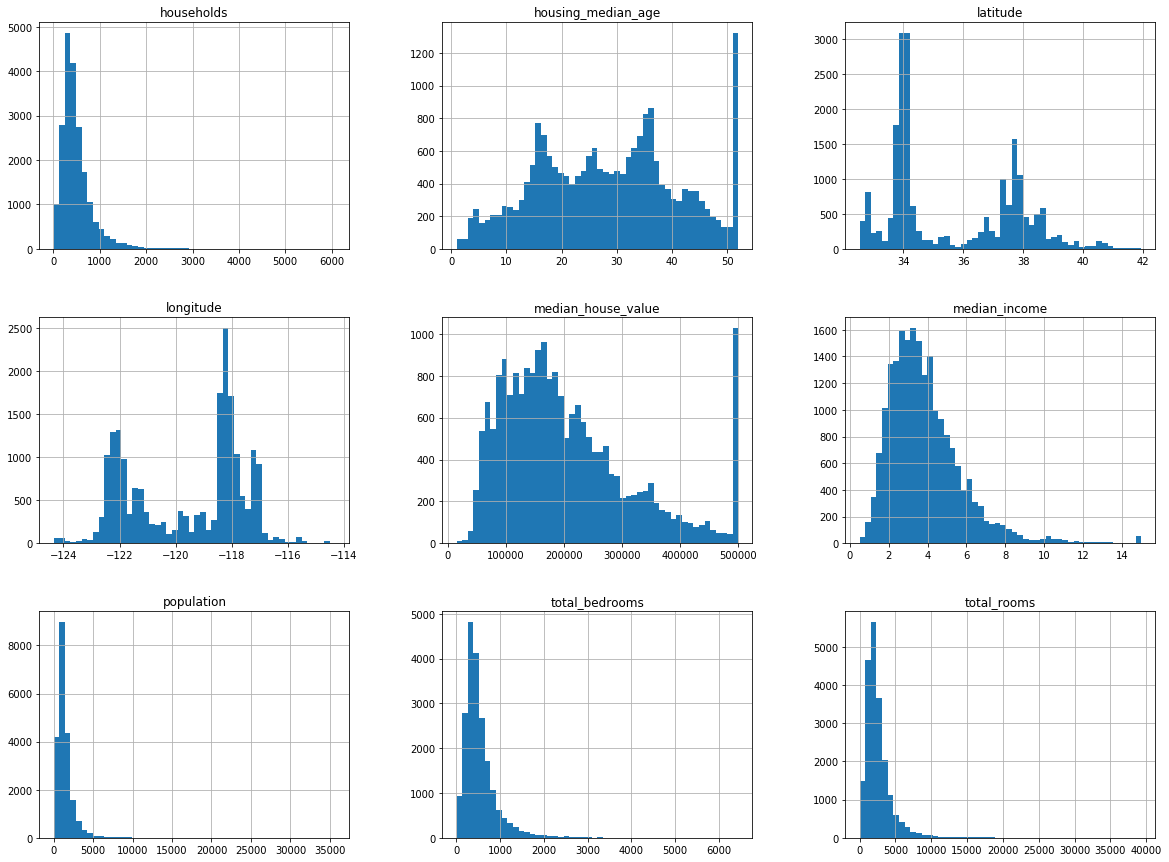

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20,15))

Things to notice

- median income is not in dollars. Roughly 1000's of $, but capped at 15
- housing median age and value are capped. Problem in ML
- Different scales
- Histograms are **tail** heavy. Much further to the right than to the left. Maybe a problem for some algos. Data will eventually be transformed to more bell-shaped distros lates

### Create a testset

Split data (80 / 20) into training and test data. it is important to always use the same data parts to be comparable. We use scikit to split the data.

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

### Stratified Sampling

In order to avoid selection bias, we have to sample not just randomly, but make sure that certain aspects / ratios which are important for our model are represented correctly in the training data. The data is subdivided into certain *strata*, where we sample from the right amount to represent the ratio of the strata in the test data.

Here the median income is important for our decision.
Most income is between 1.5 and 6. We want to divide these into 4 bins.

In [15]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0.,1.5, 3.0, 4.5, 6., np.inf],
                              labels = [1,2,3,4,5])

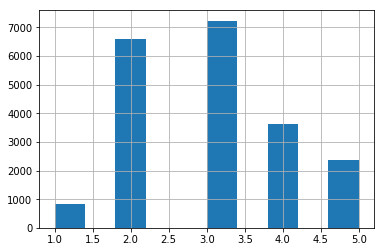

In [16]:
housing["income_cat"].hist()

Now we can do stratified sampling.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
strat_train_set.info

<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
19480    -120.97     37.66                24.0       2930.0           588.0   
8879     -118.50     34.04                52.0       2233.0           317.0   
13685    -117.24     34.15                26.0       2041.0           293.0   
4937     -118.26     33.99                47.0       1865.0           465.0   
4861     -118.28     34.02                29.0        515.0           229.0   
16365    -121.31     38.02                24.0       4157.0           951.0   
19684    -121.62    

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [23]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Now we can remove the income_cat again, we only used it for stratified sampling.

In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

## Discover and Visualize the Data

In [25]:
# make sure we only work on the training data
housing = strat_train_set.copy()

### Visualize Geopgraphical Data

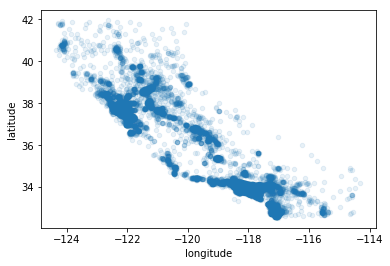

In [30]:
housing.plot(kind="scatter", x= "longitude", y = "latitude", alpha = 0.1)

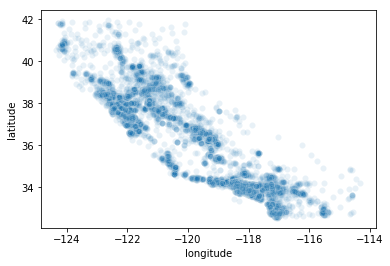

In [29]:
import seaborn as sns
sns.scatterplot( x = housing['longitude'], y= housing["latitude"], alpha = 0.1)

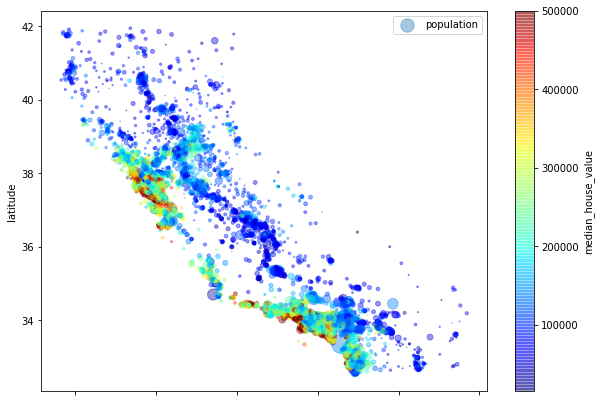

In [31]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"] / 100, label = "population",
            figsize = (10,7),
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True,
            )
plt.legend()

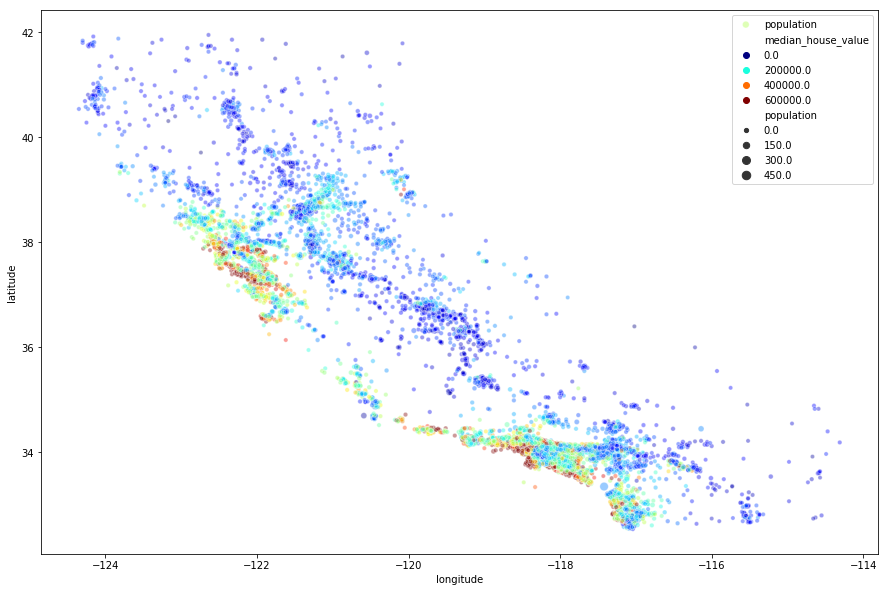

In [56]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = housing['longitude'], y= housing["latitude"], alpha = 0.4,
               size = housing["population"] / 100, label = "population",
                
                hue = housing["median_house_value"], palette = plt.get_cmap("jet")
               )




### Looking for correlations

In [57]:
corr_matrix = housing.corr()

In [59]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255BC3FB940>,
      dtype=object)

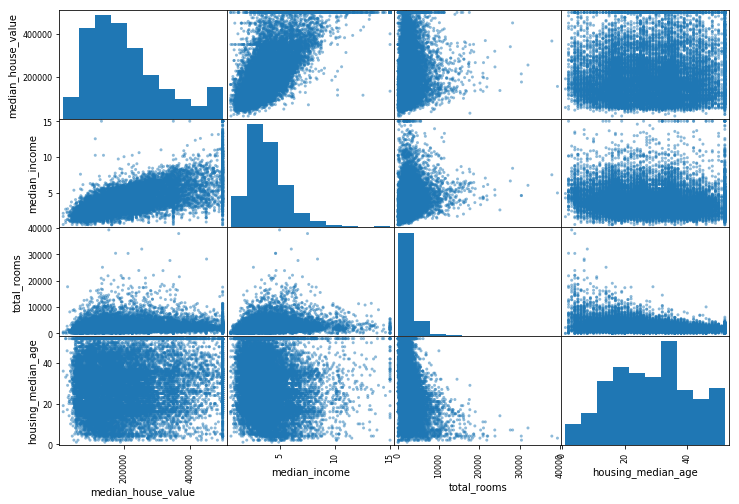

In [60]:
# create a scatter matrix, but only for chosen attributes

from pandas.plotting import scatter_matrix
attributes = ["median_house_value","median_income","total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))